# Split mini representative dataset

## 1000 image dataset

In [20]:
from createCSV import TrainTest
import config

if __name__ == "__main__":
    csv = TrainTest(
        base_dir = config.BASE_DIR,
        all_csv = config.ALL_CSV,
        train_csv = config.TRAIN_CSV,
        test_csv = config.TEST_CSV,
        label_column = config.LABEL_COLUMN,
        test_size = config.TEST_SIZE,
        seed = config.SEED)
    csv.set_all_seeds()
    csv.df()

Train set length:
755
Test set length:
245
Train set label distribution:
0    398
1    357
Name: label, dtype: int64
Test set label distribution:
1    143
0    102
Name: label, dtype: int64


In [22]:
from createCSV import TrainVal
import config

if __name__ == "__main__":
    csv1 = TrainVal(
        orig_train_csv = config.TRAIN_CSV,
        train_csv = config.TRAIN_CSV_1,
        val_csv = config.VAL_CSV_1,
        label_column = config.LABEL_COLUMN,
        val_size = config.VAL_SIZE,
        seed = config.SEED)
    csv1.set_all_seeds()
    csv1.df()

Original train set length:
755
New train set length and first n rows:
613
                                           file_name  label   parcel_id
8   22-0249080_F796528C401EECCDE0530EEE260A12DE.jpeg      0  22-0249080
9   22-0249080_F796528C45EEECCDE0530EEE260A12DE.jpeg      0  22-0249080
16  22-0249181_F7F34037674E9508E0530EEE260A6CC9.jpeg      0  22-0249181
17  22-0249181_F7F3403767749508E0530EEE260A6CC9.jpeg      0  22-0249181
18  22-0249181_F7F3403767E39508E0530EEE260A6CC9.jpeg      0  22-0249181
Val set length and first n rows:
142
                                          file_name  label   parcel_id
0  22-0248171_F796528C3E03ECCDE0530EEE260A12DE.jpeg      0  22-0248171
1  22-0248171_F796528C3E05ECCDE0530EEE260A12DE.jpeg      0  22-0248171
2  22-0248171_F796528C4450ECCDE0530EEE260A12DE.jpeg      0  22-0248171
3  22-0248171_F796528C4451ECCDE0530EEE260A12DE.jpeg      0  22-0248171
4  22-0248171_F796528C4453ECCDE0530EEE260A12DE.jpeg      0  22-0248171
Train set label distribution:
1

# Train model on mini representative dataset

In [34]:
from calculateMeanStd import MeanStdModule
import config
import torch

loader = MeanStdModule(
    config.DATA_DIR,
    config.TRAIN_CSV,
    batch_size=32,
    num_workers=1
)
loader.setup(stage = 'train')
loader.train_dataloader()

mean = 0.
std = 0.
nb_samples = 0.

for data in loader.train_dataloader():
    data = data[0]
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

mean = mean.tolist()
std = std.tolist()
print('Train set mean and std.', '\nMean: ', mean, '\nStd: ', std)

Train set mean and std. 
Mean:  [0.4883587658405304, 0.5056864023208618, 0.41416892409324646] 
Std:  [0.1856657862663269, 0.18945305049419403, 0.24573861062526703]


In [35]:
from torchvision.models import vgg16, VGG16_Weights

weights = VGG16_Weights.IMAGENET1K_V1
preprocess_transform = weights.transforms()

preprocess_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [36]:
# Train model
from model import NN
from customDataModule import CustomDataModule
import config
import pytorch_lightning as pl
from lightning.pytorch.loggers import TensorBoardLogger
from pytorch_lightning.loggers import CSVLogger
from lightning.pytorch import seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
import torch
import torchvision.models as models
import torch.nn as nn

seed_everything(
    42, workers=True
)  # By setting workers=True in seed_everything(), Lightning derives unique seeds across all dataloader workers and processes for torch, numpy and stdlib random number generators. When turned on, it ensures that e.g. data augmentations are not repeated across workers.


callbacks = [ModelCheckpoint(
    save_top_k=1, mode='min', monitor="val_loss")]  # save top 1 model 


if __name__ == "__main__":
    
    pytorch_model = models.vgg16(weights='VGG16_Weights.DEFAULT')
    
    logger = TensorBoardLogger("tb_logs", name="view") # tb_logs is the folder, name is the name of the experiment/model
    logger2 = CSVLogger(save_dir="logs/", name="view")
    
    model = NN(
        model=pytorch_model,
        input_shape=config.INPUT_SHAPE,
        num_classes=config.NUM_CLASSES,
        learning_rate=config.LEARNING_RATE,
    )  # .to(device)
    dm = CustomDataModule(
        data_dir=config.DATA_DIR,
        train_csv=config.TRAIN_CSV_1,
        val_csv=config.VAL_CSV_1,
        test_csv=config.TEST_CSV,
        batch_size=config.BATCH_SIZE,
        num_workers=config.NUM_WORKERS,
        mean=mean,
        std=std
    )
    
    trainer = pl.Trainer(
        logger=[logger2, logger],
        accelerator=config.ACCELERATOR,
        devices=config.DEVICES,
        min_epochs=config.MIN_EPOCHS,
        max_epochs=config.MAX_EPOCHS,
        deterministic=config.DETERMINISTIC,
        callbacks=callbacks
    )
      # deterministic ensures random seed reproducibility

    trainer.fit(model, dm)  # it will automatically know which dataloader to use
    
# A general place to start is to set num_workers equal to the number of CPU cores on that machine. You can get the number of CPU cores in python using os.cpu_count(), but note that depending on your batch size, you may overflow RAM memory.


Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\kaspe\.conda\envs\LBST\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory logs/view\version_0\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name            | Type             | Params
------------------------------------------------------
0  | model           | VGG              | 134 M 
1  | loss_fn         | CrossEntropyLoss | 0     
2  | train_acc       | BinaryAccuracy   | 0     
3  | val_acc         | BinaryAccuracy   | 0     
4  | test_acc        | BinaryAccuracy   | 0     
5  | train_recall    | BinaryRecall     | 0     
6  | val_recall      | BinaryRecall     | 0     
7  | test_recall     | BinaryRecall     | 0     
8  | train_preci

C:\Users\kaspe\.conda\envs\LBST\lib\site-packages\pytorch_lightning\loops\fit_loop.py:280: PossibleUserWarning: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0: 100%|██████████| 20/20 [00:10<00:00,  1.91it/s, v_num=0_8]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 20/20 [00:10<00:00,  1.83it/s, v_num=0_8, train_loss=0.670, train_accuracy=0.604, train_recall=0.570, train_precision=0.610, train_f1score=0.546]
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 20/20 [00:10<00:00,  1.85it/s, v_num=0_8, train_loss=0.584, train_accuracy=0.708, train_recall=0.757, train_precision=0.719, train_f1score=0.717]
Validation: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 20/20 [00:10<00:00,  1.91it/s, v_num=0_8, train_loss=0.572, train_accuracy=0.710, train_recall=0.671, train_precision=0.778, train_f1score=0.685]
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 20/20 [00:10<00:00,  1.93it/s, v_num=0_8, train_loss=0.512, train_accuracy=0.750, train_recall=0.745, train_precision=0.758, train_f1score=0.744]
Validation: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 20/20 [00:10<00:00,  2.00it/s, v_num=0_8, train_loss=0.510, tra

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 20/20 [00:15<00:00,  1.30it/s, v_num=0_8, train_loss=0.460, train_accuracy=0.773, train_recall=0.768, train_precision=0.795, train_f1score=0.760]


In [37]:
model

NN(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): MaxPo

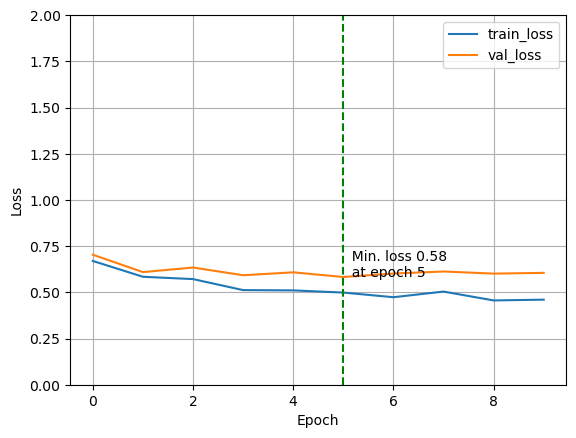

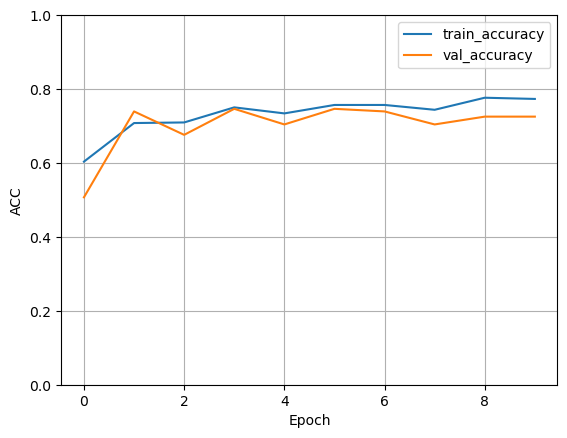

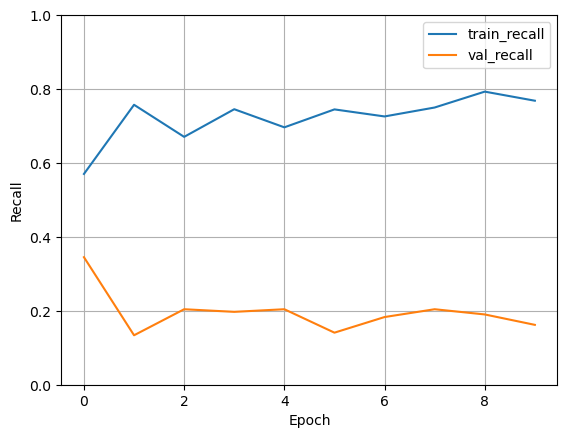

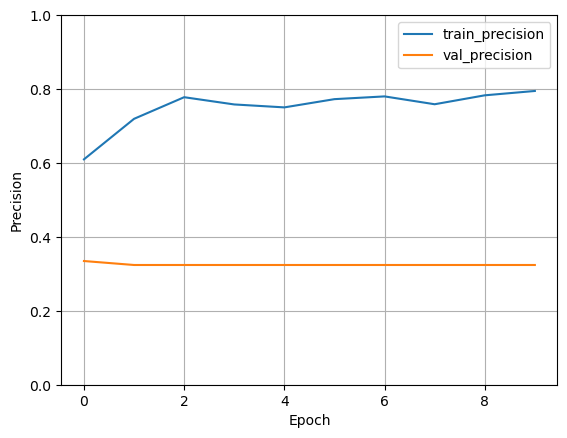

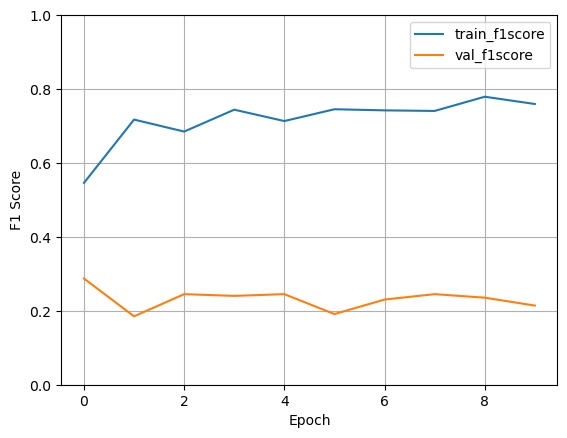

In [38]:
from plot_loss_and_acc import *
plot_loss_and_acc(trainer.logger.log_dir, loss_ylim=(0.0, 2.0), acc_ylim=(0.0, 1.0))

In [39]:
path = trainer.checkpoint_callback.best_model_path
print(path)

logs/view\version_0\checkpoints\epoch=5-step=120-v7.ckpt


In [40]:
trainer.validate(model=model, datamodule=dm, ckpt_path=path)

Restoring states from the checkpoint path at logs/view\version_0\checkpoints\epoch=5-step=120-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at logs/view\version_0\checkpoints\epoch=5-step=120-v7.ckpt


Validation DataLoader 0: 100%|██████████| 5/5 [00:01<00:00,  4.33it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7464788556098938     │
│        val_f1score        │    0.1911638081073761     │
│         val_loss          │    0.5829250812530518     │
│       val_precision       │    0.3239436745643616     │
│        val_recall         │    0.14084507524967194    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.5829250812530518,
  'val_accuracy': 0.7464788556098938,
  'val_recall': 0.14084507524967194,
  'val_precision': 0.3239436745643616,
  'val_f1score': 0.1911638081073761}]

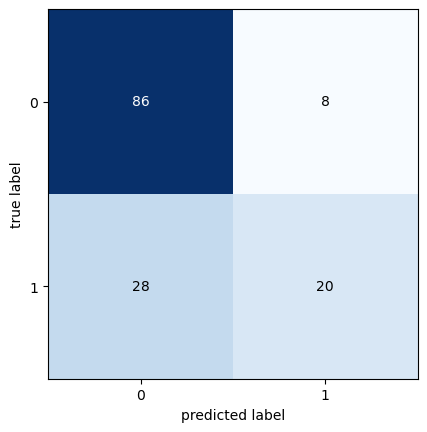

true negatives (TN): 86
false positives (FP): 8
false negatives (FN): 28
true positives (TP): 20
accuracy: 0.7464788732394366
precision: 0.7142857142857143
recall: 0.4166666666666667
f1score: 0.5263157894736842
Parcel level accuracy: 0.8065 (80.65%)


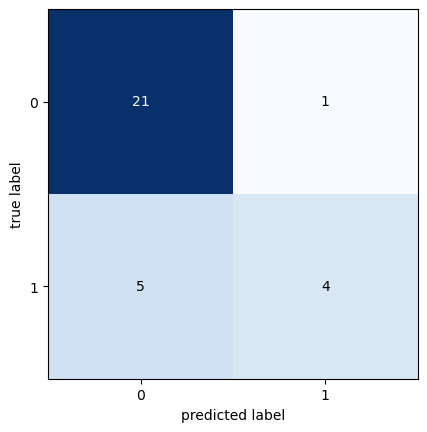

true negatives (TN): 21
false positives (FP): 1
false negatives (FN): 5
true positives (TP): 4
accuracy: 0.8064516129032258
precision: 0.8
recall: 0.4444444444444444
f1score: 0.5714285714285714


In [41]:
# Obtain validation dataset predictions
lightning_model = NN.load_from_checkpoint(
    path, model=pytorch_model)
lightning_model.eval();   

val_dataloader = dm.val_dataloader()

all_true_labels = []
all_predicted_labels = []
for batch in val_dataloader:
    features, labels = batch
    
    with torch.no_grad():
        logits = lightning_model(features)

    predicted_labels = torch.argmax(logits, dim=1)
    all_predicted_labels.append(predicted_labels)
    all_true_labels.append(labels)
    
all_predicted_labels1 = torch.cat(all_predicted_labels)
all_true_labels1 = torch.cat(all_true_labels)

from plot_loss_and_acc import *
confusion_matrix(all_predicted_labels1, all_true_labels1)
parcel_level_new(r"C:/Users/kaspe/OneDrive - Aarhus Universitet/Skrivebord/BI/4. semester/Data/LBST/train_view/val_set_1.csv", all_predicted_labels1)

In [42]:
all_predicted_labels1

tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [43]:
all_true_labels1

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [44]:
prec = torchmetrics.Precision(task='binary')
prec(all_predicted_labels1, all_true_labels1)

tensor(0.7143)

In [45]:
trainer.test(model=model, datamodule=dm, ckpt_path=path)

Restoring states from the checkpoint path at logs/view\version_0\checkpoints\epoch=5-step=120-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at logs/view\version_0\checkpoints\epoch=5-step=120-v7.ckpt


Testing DataLoader 0: 100%|██████████| 8/8 [00:01<00:00,  4.37it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6530612111091614     │
│       test_f1score        │    0.3626154661178589     │
│         test_loss         │    0.6508600115776062     │
│      test_precision       │     0.595102071762085     │
│        test_recall        │    0.28634223341941833    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6508600115776062,
  'test_acc': 0.6530612111091614,
  'test_recall': 0.28634223341941833,
  'test_precision': 0.595102071762085,
  'test_f1score': 0.3626154661178589}]

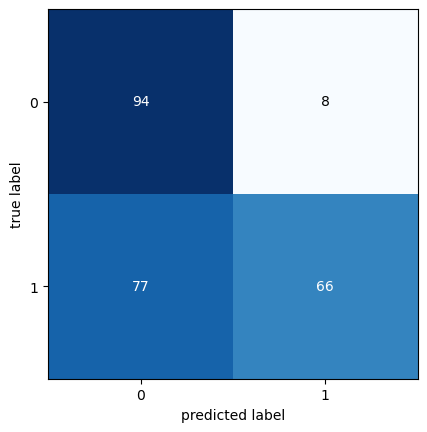

true negatives (TN): 94
false positives (FP): 8
false negatives (FN): 77
true positives (TP): 66
accuracy: 0.6530612244897959
precision: 0.8918918918918919
recall: 0.46153846153846156
f1score: 0.6082949308755761
Parcel level accuracy: 0.8205 (82.05%)


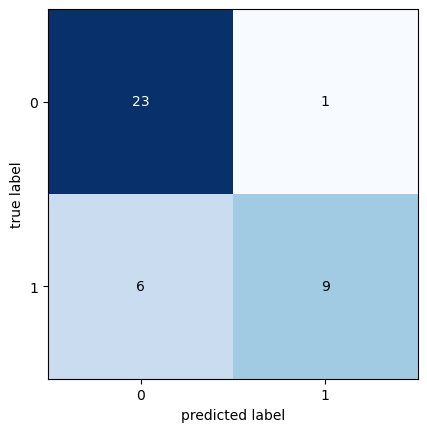

true negatives (TN): 23
false positives (FP): 1
false negatives (FN): 6
true positives (TP): 9
accuracy: 0.8205128205128205
precision: 0.9
recall: 0.6
f1score: 0.7200000000000001


In [46]:
# Obtain test dataset predictions

lightning_model = NN.load_from_checkpoint(
    path, model=pytorch_model)
lightning_model.eval();   

test_dataloader = dm.test_dataloader()

all_true_labels = []
all_predicted_labels = []
for batch in test_dataloader:
    features, labels = batch
    
    with torch.no_grad():
        logits = lightning_model(features)

    predicted_labels = torch.argmax(logits, dim=1)
    all_predicted_labels.append(predicted_labels)
    all_true_labels.append(labels)
    
all_predicted_labels2 = torch.cat(all_predicted_labels)
all_true_labels2 = torch.cat(all_true_labels)

#from plot_loss_and_acc import *
confusion_matrix(all_predicted_labels2, all_true_labels2)
parcel_level_new(r"C:/Users/kaspe/OneDrive - Aarhus Universitet/Skrivebord/BI/4. semester/Data/LBST/train_view/test_set.csv", all_predicted_labels2)

# Load best model and predict on custom datamodule

I load the best model and obtain predictions on the original test data.

In [47]:
from calculateMeanStd import MeanStdModule
import config
import torch

loader = MeanStdModule(
    r"C:/Users/kaspe/OneDrive - Aarhus Universitet/Skrivebord/BI/4. semester/Data/LBST/all",
    r"C:/Users/kaspe/OneDrive - Aarhus Universitet/Skrivebord/BI/4. semester/Data/LBST/test_set.csv",
    batch_size=32,
    num_workers=1
)
loader.setup(stage = 'train')
loader.train_dataloader()

mean = 0.
std = 0.
nb_samples = 0.

for data in loader.train_dataloader():
    data = data[0]
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

mean = mean.tolist()
std = std.tolist()
print('Original test set mean and std.', '\nMean: ', mean, '\nStd: ', std)

Original test set mean and std. 
Mean:  [0.4876338541507721, 0.5042696595191956, 0.4042126536369324] 
Std:  [0.17318908870220184, 0.17633165419101715, 0.21580712497234344]


In [48]:
from customDataModule import CustomDataModule
import config
from model import NN
from pytorch_lightning.callbacks import ModelCheckpoint
import torchvision.models as models
import pytorch_lightning as pl
from lightning.pytorch.loggers import TensorBoardLogger
from pytorch_lightning.loggers import CSVLogger
from lightning.pytorch import seed_everything
import torch
import torchvision.models as models
import torch.nn as nn

callbacks = [ModelCheckpoint(
    save_top_k=1, mode='min', monitor="val_loss")]  # save top 1 model 

if __name__ == "__main__":
    
    pytorch_model = models.vgg16(weights='VGG16_Weights.DEFAULT')
    
    logger = TensorBoardLogger("tb_logs", name="view") # tb_logs is the folder, name is the name of the experiment/model
    logger2 = CSVLogger(save_dir="logs/", name="view")
    
    model = NN(
        model=pytorch_model,
        input_shape=config.INPUT_SHAPE,
        num_classes=config.NUM_CLASSES,
        learning_rate=config.LEARNING_RATE,
    )  # .to(device)
    
    
    test_dm = CustomDataModule(
        data_dir=r"C:/Users/kaspe/OneDrive - Aarhus Universitet/Skrivebord/BI/4. semester/Data/LBST/all",
        train_csv=r"C:/Users/kaspe/OneDrive - Aarhus Universitet/Skrivebord/BI/4. semester/Data/LBST/test_set.csv",
        val_csv=r"C:/Users/kaspe/OneDrive - Aarhus Universitet/Skrivebord/BI/4. semester/Data/LBST/test_set.csv",
        test_csv=r"C:/Users/kaspe/OneDrive - Aarhus Universitet/Skrivebord/BI/4. semester/Data/LBST/test_set.csv",
        batch_size=config.BATCH_SIZE,
        num_workers=config.NUM_WORKERS,
        mean=mean,
        std=std
        )

lightning_model = NN.load_from_checkpoint(
    path, model=pytorch_model)
lightning_model.eval();    

test_dm.setup(stage = "test_set")
test_dm.test_dataloader()

# Predict using the new datamodule

test_dataloader = test_dm.test_dataloader()

all_true_labels = []
all_predicted_labels = []
for batch in test_dataloader:
    features, labels = batch
    
    with torch.no_grad():
        logits = lightning_model(features)

    predicted_labels = torch.argmax(logits, dim=1)
    all_predicted_labels.append(predicted_labels)
    all_true_labels.append(labels)
    
all_predicted_labels = torch.cat(all_predicted_labels)
all_true_labels = torch.cat(all_true_labels)

## Image-level metrics

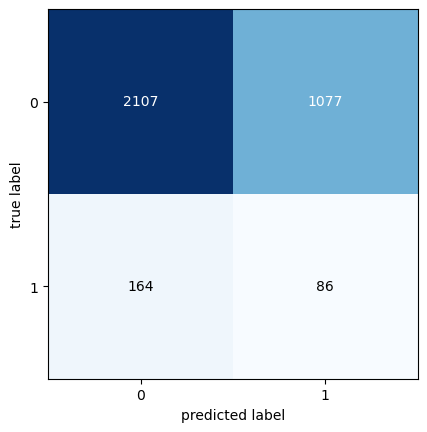

true negatives (TN): 2107
false positives (FP): 1077
false negatives (FN): 164
true positives (TP): 86
accuracy: 0.6386138613861386
precision: 0.07394668959587274
recall: 0.344
f1score: 0.12172682236376503


In [49]:
from plot_loss_and_acc import *
confusion_matrix(all_predicted_labels, all_true_labels)

## Parcel-level metrics

Parcel level accuracy: 0.7463 (74.63%)


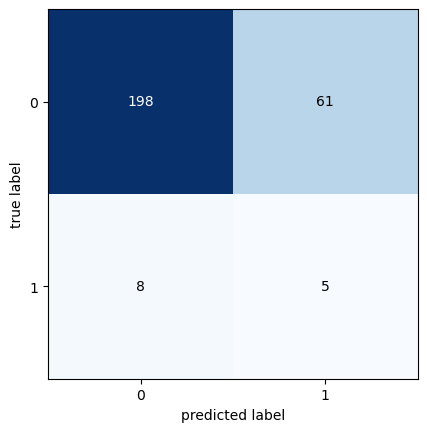

true negatives (TN): 198
false positives (FP): 61
false negatives (FN): 8
true positives (TP): 5
accuracy: 0.7463235294117647
precision: 0.07575757575757576
recall: 0.38461538461538464
f1score: 0.12658227848101267


In [50]:
from plot_loss_and_acc import *
parcel_level_new(r"C:/Users/kaspe/OneDrive - Aarhus Universitet/Skrivebord/BI/4. semester/Data/LBST/test_set.csv", all_predicted_labels)

Text(0.5, 1.0, 'P: Approved\nT: Approved')

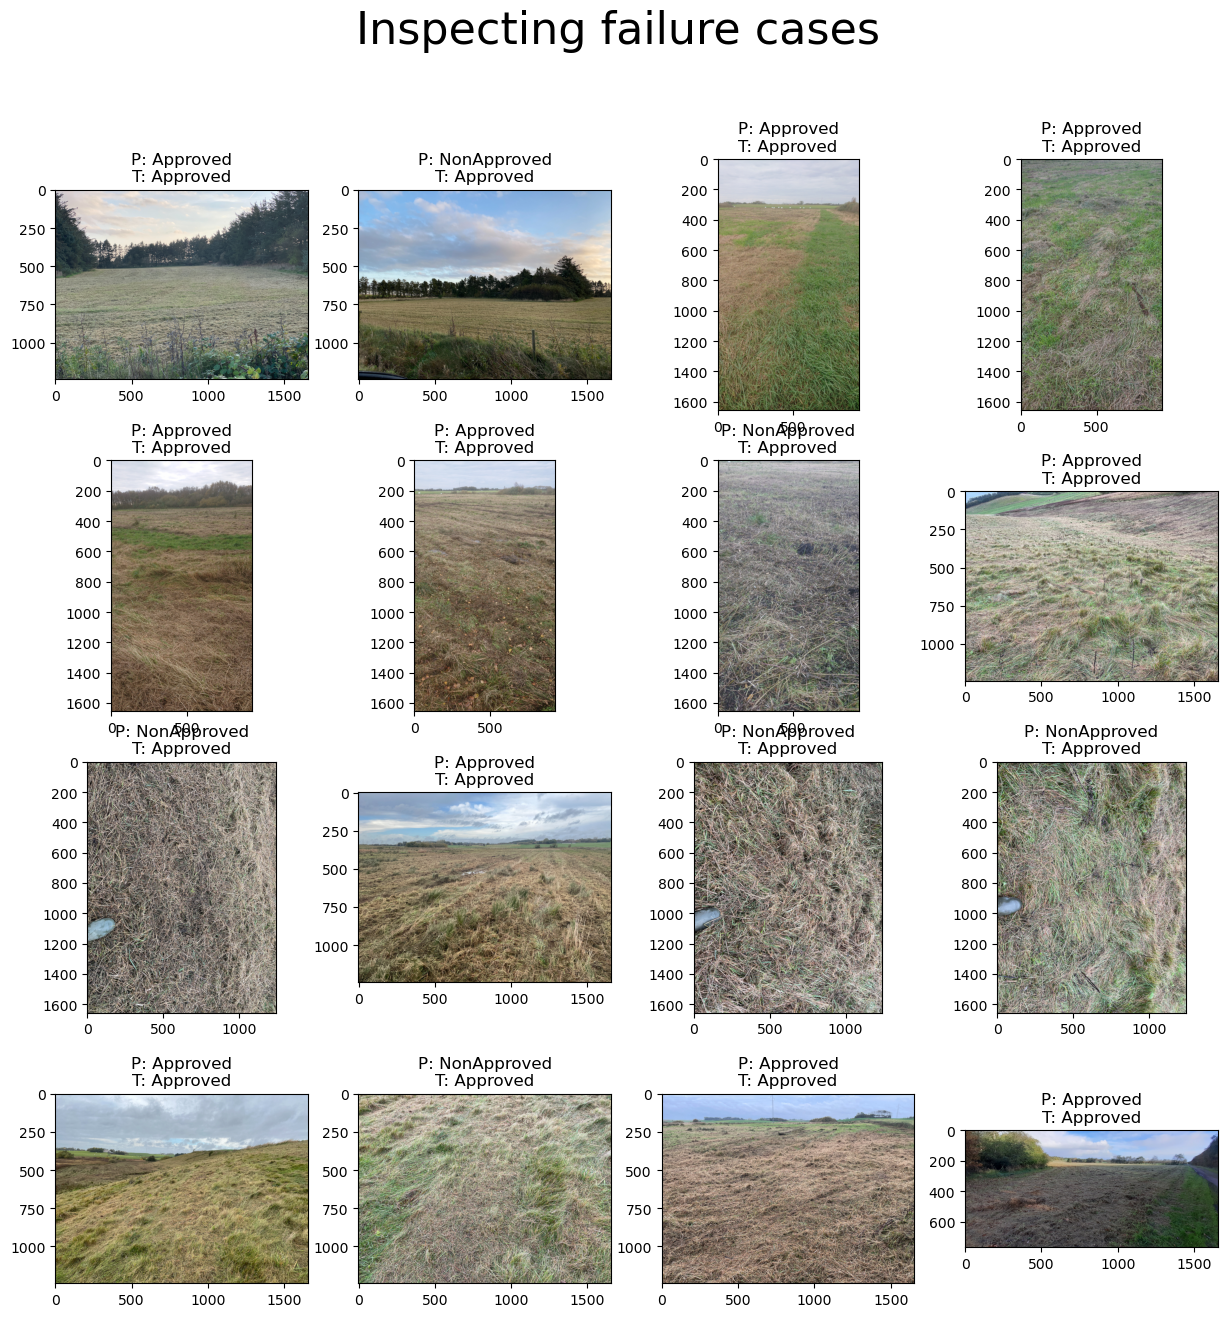

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import matplotlib.image as mpimg

base_path = r"C:/Users/kaspe/OneDrive - Aarhus Universitet/Skrivebord/BI/4. semester/Data/LBST/test/"
imgs = os.listdir(base_path)
img = base_path + imgs[1]

fig, ax = plt.subplots(4, 4, figsize=(15, 15))

fig.suptitle('Inspecting failure cases', fontsize=32)

class_dict = {0: 'Approved', 1: 'NonApproved'}

for i in range(0, 4):
    img = base_path + imgs[i]
    img = mpimg.imread(img)
    ax[0,i].imshow(img)
    ax[0,i].set_title(f'P: {class_dict[all_predicted_labels[i].item()]}'
                                f'\nT: {class_dict[all_true_labels[i].item()]}')


img = base_path + imgs[4]
img = mpimg.imread(img)
ax[1,0].imshow(img)
ax[1,0].set_title(f'P: {class_dict[all_predicted_labels[4].item()]}'
                                  f'\nT: {class_dict[all_true_labels[4].item()]}')

img = base_path + imgs[5]
img = mpimg.imread(img)
ax[1,1].imshow(img)
ax[1,1].set_title(f'P: {class_dict[all_predicted_labels[5].item()]}'
                                  f'\nT: {class_dict[all_true_labels[5].item()]}')

img = base_path + imgs[6]
img = mpimg.imread(img)
ax[1,2].imshow(img)
ax[1,2].set_title(f'P: {class_dict[all_predicted_labels[6].item()]}'
                                  f'\nT: {class_dict[all_true_labels[6].item()]}')

img = base_path + imgs[7]
img = mpimg.imread(img)
ax[1,3].imshow(img)
ax[1,3].set_title(f'P: {class_dict[all_predicted_labels[7].item()]}'
                                  f'\nT: {class_dict[all_true_labels[7].item()]}')


img = base_path + imgs[8]
img = mpimg.imread(img)
ax[2,0].imshow(img)
ax[2,0].set_title(f'P: {class_dict[all_predicted_labels[8].item()]}'
                                  f'\nT: {class_dict[all_true_labels[8].item()]}')


img = base_path + imgs[9]
img = mpimg.imread(img)
ax[2,1].imshow(img)
ax[2,1].set_title(f'P: {class_dict[all_predicted_labels[9].item()]}'
                                  f'\nT: {class_dict[all_true_labels[9].item()]}')


img = base_path + imgs[10]
img = mpimg.imread(img)
ax[2,2].imshow(img)
ax[2,2].set_title(f'P: {class_dict[all_predicted_labels[10].item()]}'
                                  f'\nT: {class_dict[all_true_labels[10].item()]}')


img = base_path + imgs[11]
img = mpimg.imread(img)
ax[2,3].imshow(img)
ax[2,3].set_title(f'P: {class_dict[all_predicted_labels[11].item()]}'
                                  f'\nT: {class_dict[all_true_labels[11].item()]}')


img = base_path + imgs[12]
img = mpimg.imread(img)
ax[3,0].imshow(img)
ax[3,0].set_title(f'P: {class_dict[all_predicted_labels[12].item()]}'
                                  f'\nT: {class_dict[all_true_labels[12].item()]}')

img = base_path + imgs[13]
img = mpimg.imread(img)
ax[3,1].imshow(img)
ax[3,1].set_title(f'P: {class_dict[all_predicted_labels[13].item()]}'
                                  f'\nT: {class_dict[all_true_labels[13].item()]}')

img = base_path + imgs[14]
img = mpimg.imread(img)
ax[3,2].imshow(img)
ax[3,2].set_title(f'P: {class_dict[all_predicted_labels[14].item()]}'
                                  f'\nT: {class_dict[all_true_labels[14].item()]}')

img = base_path + imgs[15]
img = mpimg.imread(img)
ax[3,3].imshow(img)
ax[3,3].set_title(f'P: {class_dict[all_predicted_labels[15].item()]}'
                                  f'\nT: {class_dict[all_true_labels[15].item()]}')



